# CSE 176 - Lab 6

Put your answers in solution sections, add missing code, run all code blocks.

Make sure you choose a runtime type with a GPU, e.g., T4 GPU. You don't need to subscrible to Colab Pro for such runtime type.

You are supposed to implement a multi-layer perceptron for implicit neural filed and train on ONE image only (overfitting).

Read related slides on implicit neural field: https://ucmercedcse176.github.io/files/neural_filed.pdf

###Part I
Implement a Multi-layer perceptron in pytorch that maps an image coordinate (x,y) to RGB color.



In [1]:
# complete code bellow

# Model adapted from SIREN network architecture.
# See paper "Implicit Neural Representations with Periodic Activation Functions"
# You don't need to read the paper during the lab session.
import torch
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    num_inputs = 2
    num_outputs = 3
    hidden_units_per_layer = 256
    # Initialize the modules we need to build the network
    self.linear1 = nn.Linear(num_inputs, hidden_units_per_layer) # add a linear layer that maps input to 256-dimensional hiden unit
    self.act_fn = torch.sin
    self.linear2 = nn.Linear(hidden_units_per_layer, 128) # add a linear layer that maps 256-dimensional hiden unit to 128-dimensional hiden unit
    self.act_fn2 = torch.sin
    self.linear3 = nn.Linear(128, 64) # add a linear layer that maps 128-dimensional hiden unit to 64-dimensional hiden unit
    self.act_fn3 = torch.sin
    self.linear4 = nn.Linear(64, 32) # add a linear layer that maps 64-dimensional hiden unit to 32-dimensional hiden unit
    self.act_fn4 = torch.sin
    self.linear5 = nn.Linear(32, num_outputs)
    self.act_fn5 = torch.sin

  def forward(self, x):
    # Perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = self.act_fn(x*30)
    x = self.linear2(x)
    x = self.act_fn2(x)
    x = self.linear3(x)
    x = self.act_fn3(x)
    x = self.linear4(x)
    x = self.act_fn4(x)
    x = self.linear5(x)
    x = self.act_fn5(x)
    return x

###Part II

Train the MLP for one image provided at https://ucmercedcse176.github.io/files/yosemite.png , plot loss at each training iteration.

In [3]:
import torch
from PIL import Image
import numpy as np

# load image
img = Image.open("./yosemite.png").convert('RGB')
img = np.array(img) / 255.
img = img[::2,::2,:]
img = torch.from_numpy(img) # 286, 200, 3

# training dataset
x_train = []
y_train = []
for x in range(img.shape[1]):
  for y in range(img.shape[0]):
    x_normalized = (x-(img.shape[1]/2))/(img.shape[1]/2)
    y_normalized = (y-(img.shape[0]/2))/(img.shape[0]/2)
    x_train.append((x_normalized, y_normalized))
    y_train.append(img[y, x, :])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)


# prepare dataloader

from torch.utils.data import Dataset, DataLoader

class customDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.from_numpy(x).float()
    self.y = torch.from_numpy(y).float()
  def __len__(self):
    return len(self.y)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

trainloader = DataLoader(customDataset(x_train, y_train), batch_size=512,shuffle=True)


(57200, 2)
(57200, 3)


Trained on cuda
loss for epoch 0 : 0.2994425461760589
loss for epoch 10 : 0.1701946941071323
loss for epoch 20 : 0.03573263858977173
loss for epoch 30 : 0.022896344856625155
loss for epoch 40 : 0.018529249987165843
loss for epoch 50 : 0.017425187098394548
loss for epoch 60 : 0.016927189509650425
loss for epoch 70 : 0.016546607915578142
loss for epoch 80 : 0.016206553297316923
loss for epoch 90 : 0.015905268032968576


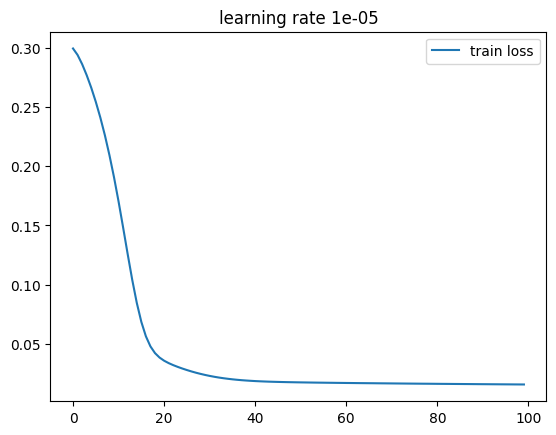

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# complete code bellow

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Trained on {}".format(device))


def train_model(lr, num_epochs):
  model = MLP()
  model = model.to(device)
  optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
  criterion = torch.nn.MSELoss()
  train_losses_epoch = [] # training loss at each epoch

  model.train()
  for epoch in range(num_epochs):
    train_losses_iterations = []
    for batch in trainloader:
      input_data, target_output = batch
      input_data = input_data.to(device)
      target_output = target_output.to(device)
      optimizer.zero_grad()

      output = model(input_data)# complete code here to get prediction
      loss = criterion(output, target_output)# complete code here
      loss.backward()
      optimizer.step()
      # complete code for optimizer and loss

      train_losses_iterations.append(loss.cpu().detach().item())
    if epoch%10 ==0:
      print(f"loss for epoch {epoch} : {np.mean(train_losses_iterations)}")
    train_losses_epoch.append(np.mean(train_losses_iterations))
    # update learning rate at the end of each epoch
    scheduler.step()



  plt.plot(train_losses_epoch, label='train loss')
  plt.legend()
  plt.title(f"learning rate {lr}")
  plt.show()
  return model

model = train_model(lr=1e-5, num_epochs=100)


loss for epoch 0 : 0.083267366887802
loss for epoch 10 : 0.01246020883887208
loss for epoch 20 : 0.013204469927586615
loss for epoch 30 : 0.015697641032082692
loss for epoch 40 : 0.016730192599685063
loss for epoch 50 : 0.017212018295789937
loss for epoch 60 : 0.017680025734339973
loss for epoch 70 : 0.018675697651425644
loss for epoch 80 : 0.019303102370551124
loss for epoch 90 : 0.02036944020073861


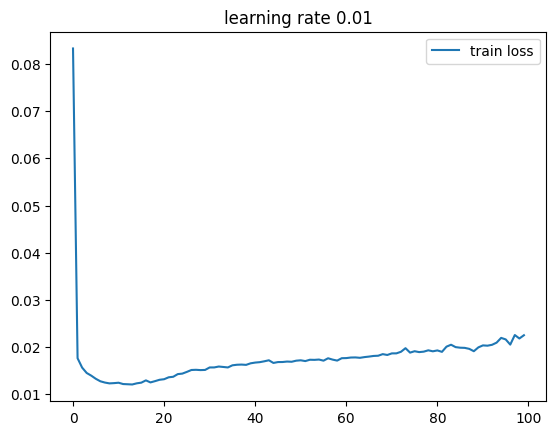

loss for epoch 0 : 0.2091387674611594
loss for epoch 10 : 0.013879978912882507
loss for epoch 20 : 0.012379866367804684
loss for epoch 30 : 0.01112533698324114
loss for epoch 40 : 0.010003653803973325
loss for epoch 50 : 0.009285668705290715
loss for epoch 60 : 0.008786790991767443
loss for epoch 70 : 0.008413521481478321
loss for epoch 80 : 0.008078353034631749
loss for epoch 90 : 0.007791512354742736


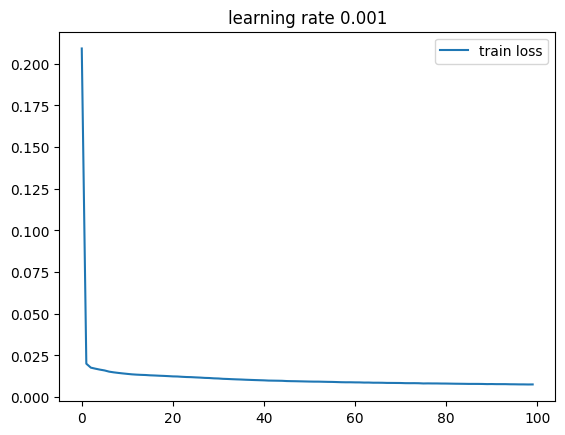

In [5]:
# Try different learning rates, explain how the learning rates affects training losses
model=train_model(lr=1e-2, num_epochs=100)

model=train_model(lr=1e-3, num_epochs=100)

###Part III

Once the network is trained, predict RGB color at each pixel location, visualize generated image. Also visualize difference between generated image and original image.

loss for epoch 0 : 0.19711468676437757
loss for epoch 10 : 0.01385998954564067
loss for epoch 20 : 0.01250694626443354
loss for epoch 30 : 0.011226427882710206
loss for epoch 40 : 0.01012374138060425
loss for epoch 50 : 0.009331213938172109
loss for epoch 60 : 0.008773475278368486
loss for epoch 70 : 0.008354525115074856
loss for epoch 80 : 0.008009320416022092
loss for epoch 90 : 0.007709403904820127


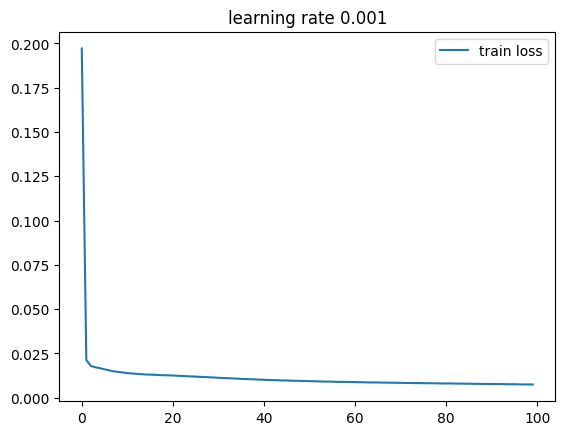

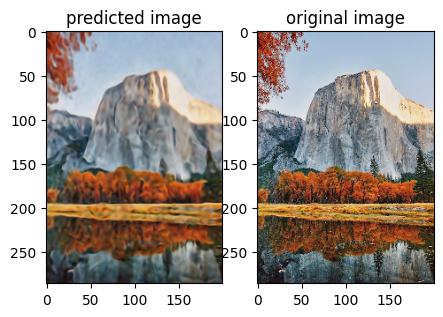

In [6]:
# with the best learning rate you find, train a model and run inference to predict the image
model=train_model(lr=1e-3, num_epochs=100)


import matplotlib.pyplot as plt
trainloader_unshuffle = DataLoader(customDataset(x_train, y_train),batch_size=512, shuffle=False)
pixels = []


for x, y in trainloader_unshuffle:
  x = x.to(device)
  pred = model(x).cpu().detach().numpy()
  pixels.append(pred)
pixels = np.concatenate(pixels, axis=0)
pred_img = pixels.reshape(img.shape[1], img.shape[0], -1)
pred_img = np.transpose(pred_img, (1, 0, 2))

pred_img[pred_img < 0] = 0
pred_img[pred_img > 1] = 1
fig, ax = plt.subplots(1, 2, figsize=(5, 16))
ax[0].imshow(pred_img)
ax[0].set_title("predicted image")
ax[1].imshow(img)
ax[1].set_title("original image")
plt.show()